In [89]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data

https://population.un.org/wpp/downloads?folder=Standard%20Projections&group=CSV%20format

## Life table

* mx: Central death rate, nmx, for the age interval (x, x+n)
* qx: Probability of dying (nqx), for an individual between age x and x+n
* px: Probability of surviving, (npx), for an individual of age x to age x+n
* lx: Number of survivors, (lx), at age (x) for 100000 births
* dx: Number of deaths, (ndx), between ages x and x+n
* Lx: Number of person-years lived, (nLx), between ages x and x+n
* Sx: Survival ratio (nSx) corresponding to proportion of the life table population in age group (x, x+n) who are alive n year later
* Tx: Person-years lived, (Tx), above age x
* ex: Expectation of life (ex) at age x, i.e., average number of years lived subsequent to age x by those reaching age x
* ax: Average number of years lived (nax) between ages x and x+n by those dying in the interval

# Life expectancy

In [247]:
df.columns

Index(['SortOrder', 'LocID', 'Notes', 'ISO3_code', 'ISO2_code', 'SDMX_code',
       'LocTypeID', 'LocTypeName', 'ParentID', 'Location', 'VarID', 'Variant',
       'Time', 'MidPeriod', 'SexID', 'Sex', 'AgeGrp', 'AgeGrpStart',
       'AgeGrpSpan', 'mx', 'qx', 'px', 'lx', 'dx', 'Lx', 'Sx', 'Tx', 'ex',
       'ax'],
      dtype='object')

In [246]:
df = pd.read_csv("data/WPP2024_Life_Table_Abridged_Medium_1950-2023.csv")

/var/folders/50/qly_r7y17754hf5lyq92cnjh0000gn/T/ipykernel_41892/1876737305.py:1: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/WPP2024_Life_Table_Abridged_Medium_1950-2023.csv")


In [248]:
df = df.dropna(subset=['ISO3_code', 'ISO2_code', 'SDMX_code'])

In [249]:
df.to_csv("data/WPP2024_Life_Table_Abridged_Medium_1950-2023-2.csv")

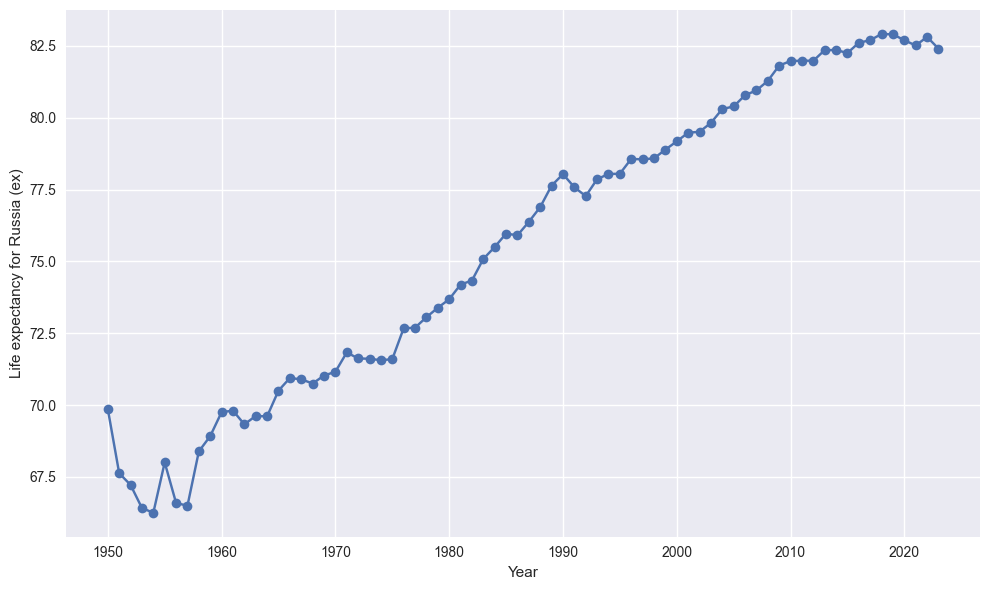

In [151]:
df_kz = df[
    (df["ISO3_code"] == "ISR") &
    (df['Sex'] == 'Total') &
    ((df['AgeGrpStart'] == 0) | (df['AgeGrp'] == '0-1'))# &
   #(df["Time"] == 2023)
]

df_kz = df_kz.sort_values('Time')

years = df_kz['Time']
life_expectancy = df_kz['ex']


plt.figure(figsize=(10,6))
plt.plot(years, life_expectancy, marker='o')
plt.xlabel('Year')
plt.ylabel('Life expectancy (ex)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Life expectancy calculation

In [154]:
df_kz = df_kz[df_kz["Time"] == 2023]

In [155]:
# mortality rate in the age range
mx = df_kz['mx']

In [156]:
mx

1953578    0.002787
Name: mx, dtype: float64

### Calculate $q_{x}$ (the probability of dying in the age range) from $m_{x}$

$q_x = \frac{n \cdot m_x}{1 + (n - a_x) \cdot m_x}$

where

$n$ - length of the age interval

$a_x$ - average number of person-years lived in the interval by those who died in that interval

However, $a_x$ is usually difficult to calculate, and approximations are often used. In demography, for ages 5 years and above, $a_x = n/2$ is commonly used.

For infants (age 0), $a_x$ is typically taken as approximately 0.1-0.3, and for ages 1-4 years - approximately 1.5.

However, in our case, to avoid complicating matters, we can use simplified formulas if we do not know $a_x$. However, the data already contains $a_x$, but according to the conditions, we should not use them. Therefore, we will use standard approximations for $a_x$.

Standard approximations for $a_x$ (from UN methodology):

For age 0: $(a_{0} = 0.1 + 1.5 \cdot m_{0})$ (if the infant mortality rate is high, it may be 0.3, but we have data, so we could try to calculate from the available data, but we cannot use pre-calculated $a_{x}$, so we use the approximation)

For ages 1-4: ($a_{1}$ = 1.5)

For ages 5-9, 10-14, ...: ($a_{x}$ = 2.5) (when $n=5$)

However, to be precise, we could calculate $a_x$ from the available data, but this is complex. Therefore, we will use standard approximations.

In [157]:
import numpy as np


def calculate_qx(df):

    """Calculates probability of dying"""
    conditions = [
        df['AgeGrpStart'] == 0,  # infant
        df['AgeGrpSpan'] == 1,   # one-year
        df['AgeGrpSpan'] > 1     # others
    ]
    
    choices = [
        df['mx'] / (1 + (1 - df['ax']) * df['mx']),  # for a_0
        df['mx'] / (1 + (1 - 0.5) * df['mx']),       # for a_1 
        (df['AgeGrpSpan'] * df['mx']) / (1 + (df['AgeGrpSpan'] - 0.5) * df['mx'])  # for others
    ]
    
    return np.select(conditions, choices)

In [158]:
# Probability of survival (px)
# px = 1 - qx
df_kz['qx_calc'] = calculate_qx(df_kz)
df_kz['px_calc'] = 1 - df_kz['qx_calc']

In [159]:
# Number of survivors (lx)

# lx = lx_previous * px_previous for each cohort

def calculate_lx(df):
    lx_values = [100000]  # Начальная когорта
    
    for i in range(1, len(df)):
        lx_prev = lx_values[-1]
        px_prev = df.iloc[i-1]['px_calc']
        lx_values.append(lx_prev * px_prev)
    
    return lx_values

In [160]:
df_kz['lx_calc'] = calculate_lx(df_kz)

In [161]:
# Number of people dying (dx)

df_kz['dx_calc'] = df_kz['lx_calc'] * df_kz['qx_calc']

In [162]:
# Man-years lived (Lx)

def calculate_Lx(df):
    Lx_values = []
    
    for i, row in df.iterrows():
        if row['AgeGrpSpan'] > 0:
            Lx = row['AgeGrpSpan'] * (row['lx_calc'] - row['dx_calc']) + row['ax'] * row['dx_calc']
        else:  # Для открытого интервала (100+)
            Lx = row['lx_calc'] / row['mx'] if row['mx'] > 0 else 0
        Lx_values.append(Lx)
    
    return Lx_values

df_kz["Lx_calc"] = calculate_Lx(df_kz)


In [163]:
# Total man-years
# Tx = sum(Lx_from_current_to_end)
df_kz['Tx_calc'] = df_kz['Lx_calc'][::-1].cumsum()[::-1]

In [164]:
# Life expectancy (ex)

df_kz['ex_calc'] = df_kz['Tx_calc'] / df_kz['lx_calc']


In [167]:
df_example = df[
    (df["ISO3_code"] == "ISR") &
    (df['Sex'] == 'Total') &
    # (df['Variant'] == 'Medium') #&
    #((df['AgeGrpStart'] == 0) | (df['AgeGrp'] == '0-1')) &
    (df["Time"] == 2023)
]


df_example['qx_calc'] = calculate_qx(df_example)
df_example['px_calc'] = 1 - df_example['qx_calc']
df_example['lx_calc'] = calculate_lx(df_example)
df_example['dx_calc'] = df_example['lx_calc'] * df_example['qx_calc']
df_example['Lx_calc'] = calculate_Lx(df_example)
df_example['Tx_calc'] = df_example['Lx_calc'][::-1].cumsum()[::-1]
df_example['ex_calc'] = df_example['Tx_calc'] / df_example['lx_calc']

print("Comparison of calculated and initial values of ex:")
print(f"e0 calculated: {df_example['ex_calc'].iloc[0]:.2f}")
print(f"e0 initial: {df_example['ex'].iloc[0]:.2f}")

Comparison of calculated and initial values of ex:
e0 calculated: 83.29
e0 initial: 82.41


/var/folders/50/qly_r7y17754hf5lyq92cnjh0000gn/T/ipykernel_41892/1474416181.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_example['qx_calc'] = calculate_qx(df_example)
/var/folders/50/qly_r7y17754hf5lyq92cnjh0000gn/T/ipykernel_41892/1474416181.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_example['px_calc'] = 1 - df_example['qx_calc']
/var/folders/50/qly_r7y17754hf5lyq92cnjh0000gn/T/ipykernel_41892/1474416181.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

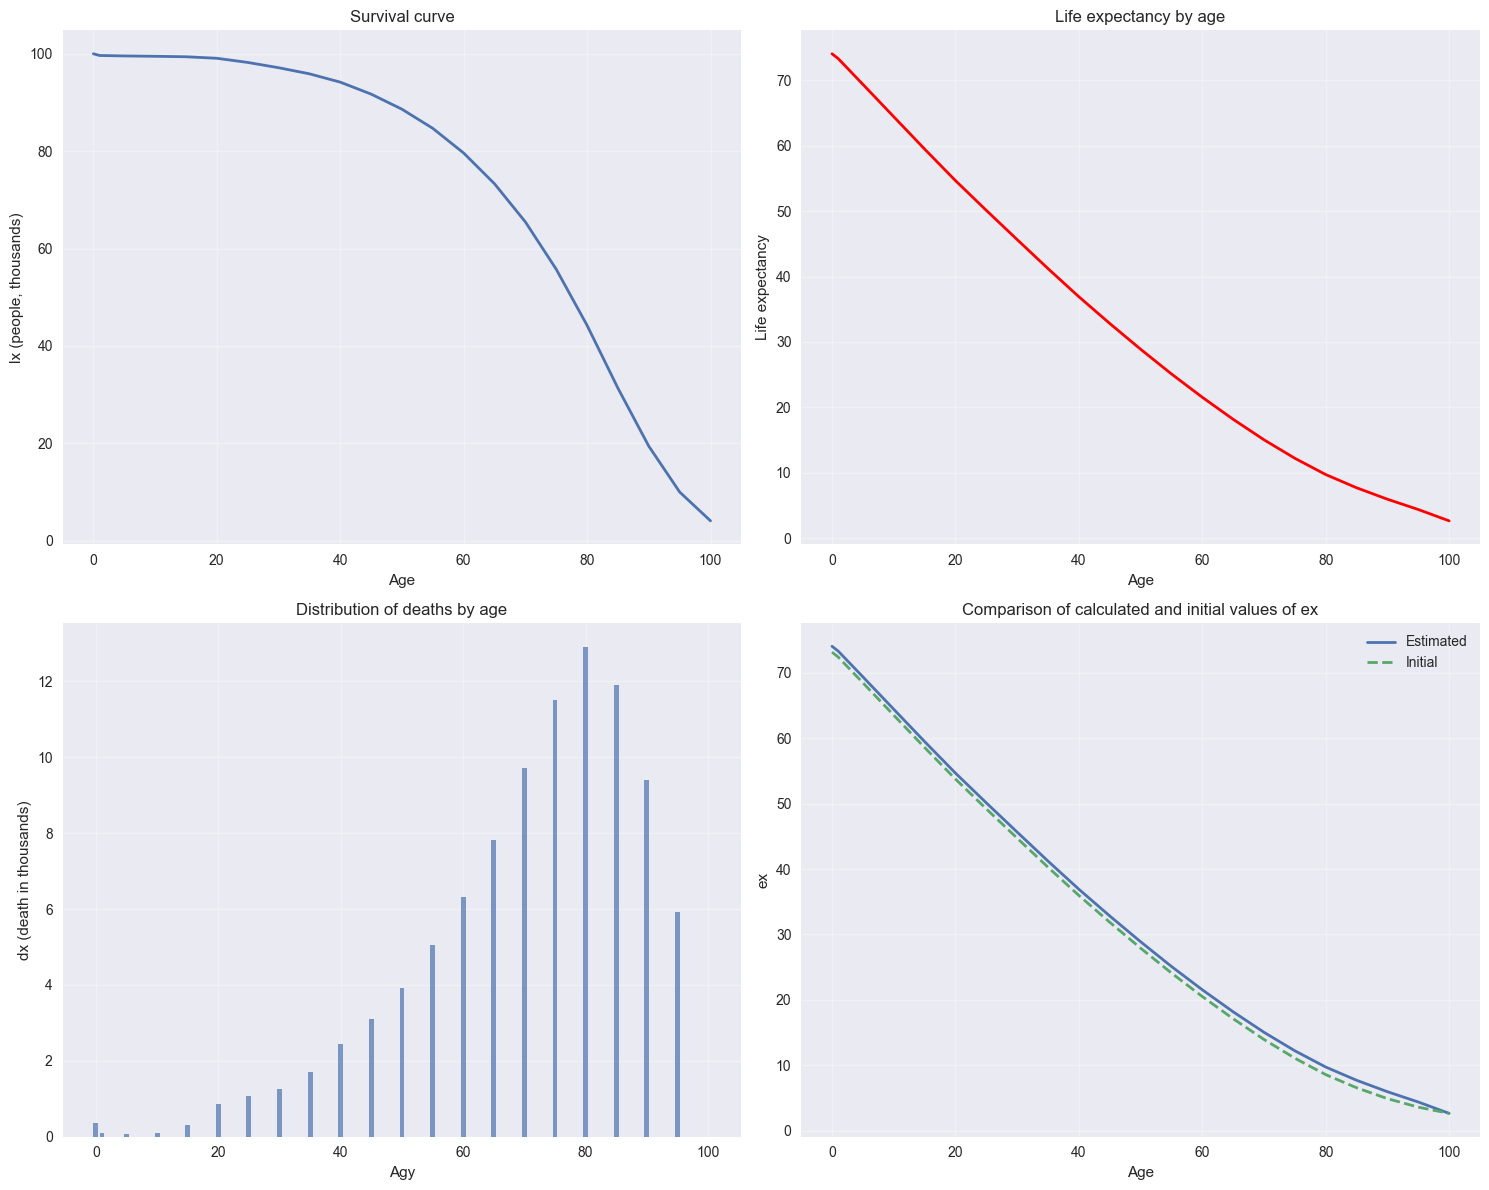

In [86]:
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Survival curve
axes[0,0].plot(df_example['AgeGrpStart'], df_example['lx_calc'] / 1000, linewidth=2)
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('lx (people, thousands)')
axes[0,0].set_title('Survival curve')
axes[0,0].grid(True, alpha=0.3)

# Survival function
axes[0,1].plot(df_example['AgeGrpStart'], df_example['ex_calc'], linewidth=2, color='red')
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Life expectancy')
axes[0,1].set_title('Life expectancy by age')
axes[0,1].grid(True, alpha=0.3)

# 3. Distribution of deaths (dx)
axes[1,0].bar(df_example['AgeGrpStart'], df_example['dx_calc']/1000, alpha=0.7)
axes[1,0].set_xlabel('Agy')
axes[1,0].set_ylabel('dx (death in thousands)')
axes[1,0].set_title('Distribution of deaths by age')
axes[1,0].grid(True, alpha=0.3)

# 4. Comparison of calculated and initial values of ex
axes[1,1].plot(df_example['AgeGrpStart'], df_example['ex_calc'], label='Estimated', linewidth=2)
axes[1,1].plot(df_example['AgeGrpStart'], df_example['ex'], label='Initial', linestyle='--', linewidth=2)
axes[1,1].set_xlabel('Age')
axes[1,1].set_ylabel('ex')
axes[1,1].set_title('Comparison of calculated and initial values of ex')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Median age at death: 80 years


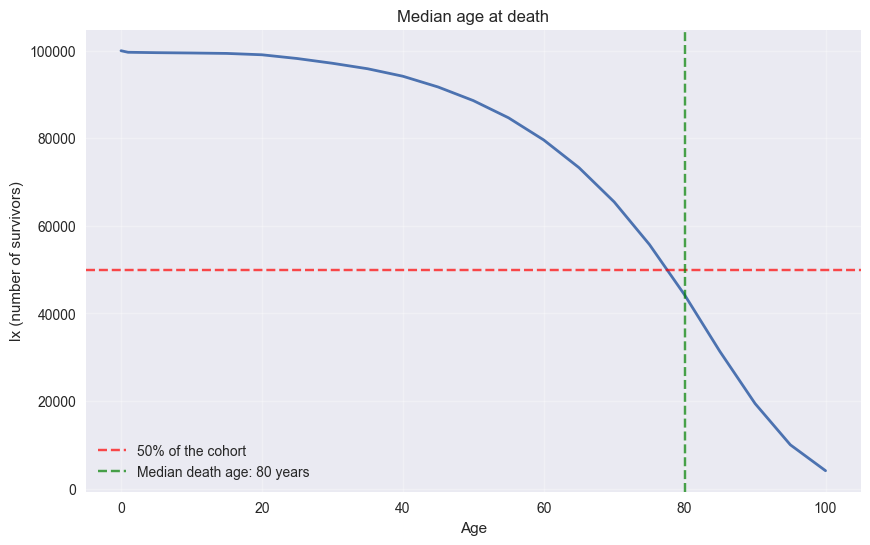

In [95]:
# Median age at death is the age at which 50% of the cohort remains
median_death_age = df_example[df_example['lx_calc'] <= 50000]['AgeGrpStart'].iloc[0]
print(f"Median age at death: {median_death_age} years")

plt.figure(figsize=(10, 6))
plt.plot(df_example['AgeGrpStart'], df_example['lx_calc'], linewidth=2)
plt.axhline(y=50000, color='red', linestyle='--', alpha=0.7, label='50% of the cohort')
plt.axvline(x=median_death_age, color='green', linestyle='--', alpha=0.7, label=f'Median death age: {median_death_age} years')
plt.xlabel('Age')
plt.ylabel('lx (number of survivors)')
plt.title('Median age at death')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Death rate

In [140]:
death = pd.read_csv("data/WPP2024_DeathsBySingleAgeSex_Medium_1950-2023.csv")

/var/folders/50/qly_r7y17754hf5lyq92cnjh0000gn/T/ipykernel_41892/88102847.py:1: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  death = pd.read_csv("data/WPP2024_DeathsBySingleAgeSex_Medium_1950-2023.csv")


## Death rate table

* SortOrder is the sequential number of the record (probably for sorting).
* LocID is the identifier of the location (country or region). Here 380 is the Italian code.
* Notes - notes (missing from the data).
* ISO3_code is a three-letter country code (ITA - Italy).
* ISO2_code is a two-letter country code (IT is Italy).
* SDMX_code is the code in the SDMX (Statistical Data and Metadata Exchange) format (380.0).
* LocTypeID is the type of location (4.0 is the country/territory).
* LocTypeName - the name of the location type (Country/Area).
* ParentID is the identifier of the parent location (925.0 is probably the area code of Italy).
* Location - the name of the location (Italy).
* VarID is the identifier of the variant (2 is probably the average forecast variant).
* Variant is the name of the variant (Medium is the average variant).
* Time is the year (1950, 1951, ... 2023).
* MidPeriod is the middle of the period (1950.5 - mid-1950).
* AgeGrp - age group code (0, 1, 2, ... 100+).
* AgeGrpStart - the beginning of the age range (0, 1, 2, ... 100).
* AgeGrpSpan is the length of the age range (1 year, except for the last group of 100+, where -1 stands, which probably means an open interval).
* DeathMale is the number of deaths of men (in thousands) in a given age group per year.
* DeathFemale is the number of deaths of women (in thousands) in a given age group per year.
* DeathTotal is the total number of deaths (in thousands) in a given age group per year.

In [170]:
death_it = death[death["ISO3_code"] == "RUS"]
death_it.head()

,SortOrder,LocID,Notes,ISO3_code,ISO2_code,SDMX_code,LocTypeID,LocTypeName,ParentID,Location,VarID,Variant,Time,MidPeriod,AgeGrp,AgeGrpStart,AgeGrpSpan,DeathMale,DeathFemale,DeathTotal
3139080,192.0,643,NaN,RUS,RU,643.0,4.0,Country/Area,923.0,Russian Federation,2,Medium,1950,1950.5,0,0,1,179.459,143.110,322.569
3139081,192.0,643,NaN,RUS,RU,643.0,4.0,Country/Area,923.0,Russian Federation,2,Medium,1950,1950.5,1,1,1,39.630,38.064,77.694
3139082,192.0,643,NaN,RUS,RU,643.0,4.0,Country/Area,923.0,Russian Federation,2,Medium,1950,1950.5,2,2,1,18.375,16.563,34.938
3139083,192.0,643,NaN,RUS,RU,643.0,4.0,Country/Area,923.0,Russian Federation,2,Medium,1950,1950.5,3,3,1,10.510,9.231,19.741
3139084,192.0,643,NaN,RUS,RU,643.0,4.0,Country/Area,923.0,Russian Federation,2,Medium,1950,1950.5,4,4,1,5.494,4.770,10.264


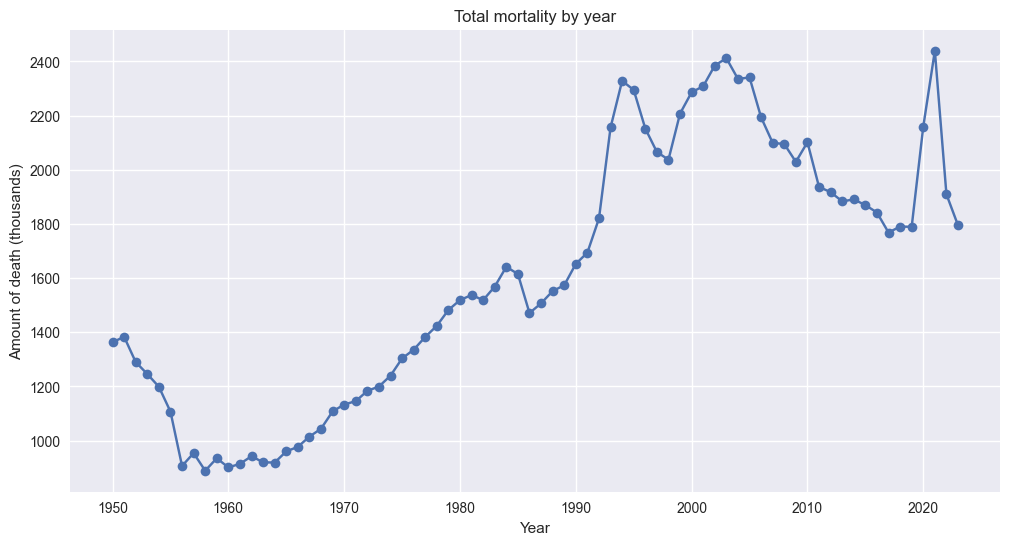

In [171]:
# Total mortality by year
yearly_mortality = death_it.groupby('Time')['DeathTotal'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(yearly_mortality['Time'], yearly_mortality['DeathTotal'], marker='o')
plt.title('Total mortality by year')
plt.xlabel('Year')
plt.ylabel('Amount of death (thousands)')
plt.grid(True)
plt.show()

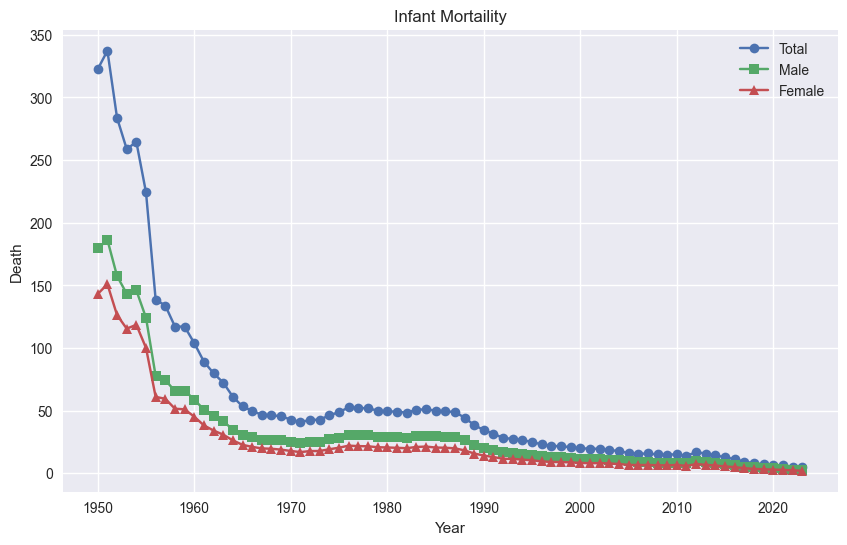

In [173]:
# infant mortality (возраст 0)
infant_mortality = death_it[death_it['AgeGrpStart'] == 0][['Time', 'DeathTotal', 'DeathMale', 'DeathFemale']]

plt.figure(figsize=(10, 6))
plt.plot(infant_mortality['Time'], infant_mortality['DeathTotal'], marker='o', label='Total')
plt.plot(infant_mortality['Time'], infant_mortality['DeathMale'], marker='s', label='Male')
plt.plot(infant_mortality['Time'], infant_mortality['DeathFemale'], marker='^', label='Female')
plt.title('Infant Mortaility')
plt.xlabel('Year')
plt.ylabel('Death')
plt.legend()
plt.grid(True)
plt.show()

# Linear regression

## Join datasets

In [178]:
list1 = df.columns.tolist()

list2 = death.columns.tolist()

common_columns = [col for col in list1 if col in list2]


['SortOrder', 'LocID', 'Notes', 'ISO3_code', 'ISO2_code', 'SDMX_code', 'LocTypeID', 'LocTypeName', 'ParentID', 'Location', 'VarID', 'Variant', 'Time', 'MidPeriod', 'AgeGrp', 'AgeGrpStart', 'AgeGrpSpan']


In [223]:
target = "DeathTotal"
features = ["dx", "lx", "Lx", "Sx", "ex", "ax"]
time_column = "Time"
index_column = "Location"

In [184]:
df_lin_reg = pd.merge(df, death, on=common_columns, how="inner")
print(df_lin_reg.shape)
df_lin_reg.head()

,SortOrder,LocID,Notes,ISO3_code,ISO2_code,SDMX_code,LocTypeID,LocTypeName,ParentID,Location,...,lx,dx,Lx,Sx,Tx,ex,ax,DeathMale,DeathFemale,DeathTotal
0,NaN,5507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADB region: Central and West Asia,...,100000.000,21819.033,85257.099,0.732072,3810819.176,38.1082,0.324310,324.189,275.913,600.102
1,NaN,5507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADB region: Central and West Asia,...,6.040,6.040,9.027,0.000000,9.027,1.4945,1.494500,0.042,0.155,0.197
2,NaN,5507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADB region: Central and West Asia,...,100000.000,21177.897,85685.120,0.742967,3913326.675,39.1333,0.324065,324.998,275.826,600.824
3,NaN,5507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADB region: Central and West Asia,...,6.375,6.375,9.821,0.000000,9.821,1.5405,1.540500,0.066,0.158,0.224
4,NaN,5507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADB region: Central and West Asia,...,100000.000,20626.472,86055.159,0.752240,4007907.676,40.0791,0.323935,325.548,277.100,602.648


## Data Cleaning

In [189]:
df_lin_reg = df_lin_reg[~df_lin_reg["ISO3_code"].isnull()]
df_lin_reg.shape

In [201]:
df_lin_reg = df_lin_reg.drop_duplicates(subset=features)
print(df_lin_reg.shape)

(105185, 32)


In [202]:
df_lin_reg["Location"].unique()

array(['Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya',
       'Madagascar', 'Malawi', 'Mauritius', 'Mayotte', 'Mozambique',
       'Réunion', 'Rwanda', 'Seychelles', 'Somalia', 'South Sudan',
       'Uganda', 'United Republic of Tanzania', 'Zambia', 'Zimbabwe',
       'Angola', 'Cameroon', 'Central African Republic', 'Chad', 'Congo',
       'Democratic Republic of the Congo', 'Equatorial Guinea', 'Gabon',
       'Sao Tome and Principe', 'Algeria', 'Egypt', 'Libya', 'Morocco',
       'Sudan', 'Tunisia', 'Western Sahara', 'Botswana', 'Eswatini',
       'Lesotho', 'Namibia', 'South Africa', 'Benin', 'Burkina Faso',
       'Cabo Verde', "Côte d'Ivoire", 'Gambia', 'Ghana', 'Guinea',
       'Guinea-Bissau', 'Liberia', 'Mali', 'Mauritania', 'Niger',
       'Nigeria', 'Saint Helena', 'Senegal', 'Sierra Leone', 'Togo',
       'Kazakhstan', 'Kyrgyzstan', 'Tajikistan', 'Turkmenistan',
       'Uzbekistan', 'China', 'China, Hong Kong SAR', 'China, Macao SAR',
       'China, Taiwan

In [205]:
df_lin_reg[df_lin_reg["Location"] == "Armenia"]["Time"].unique()

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

## EDA

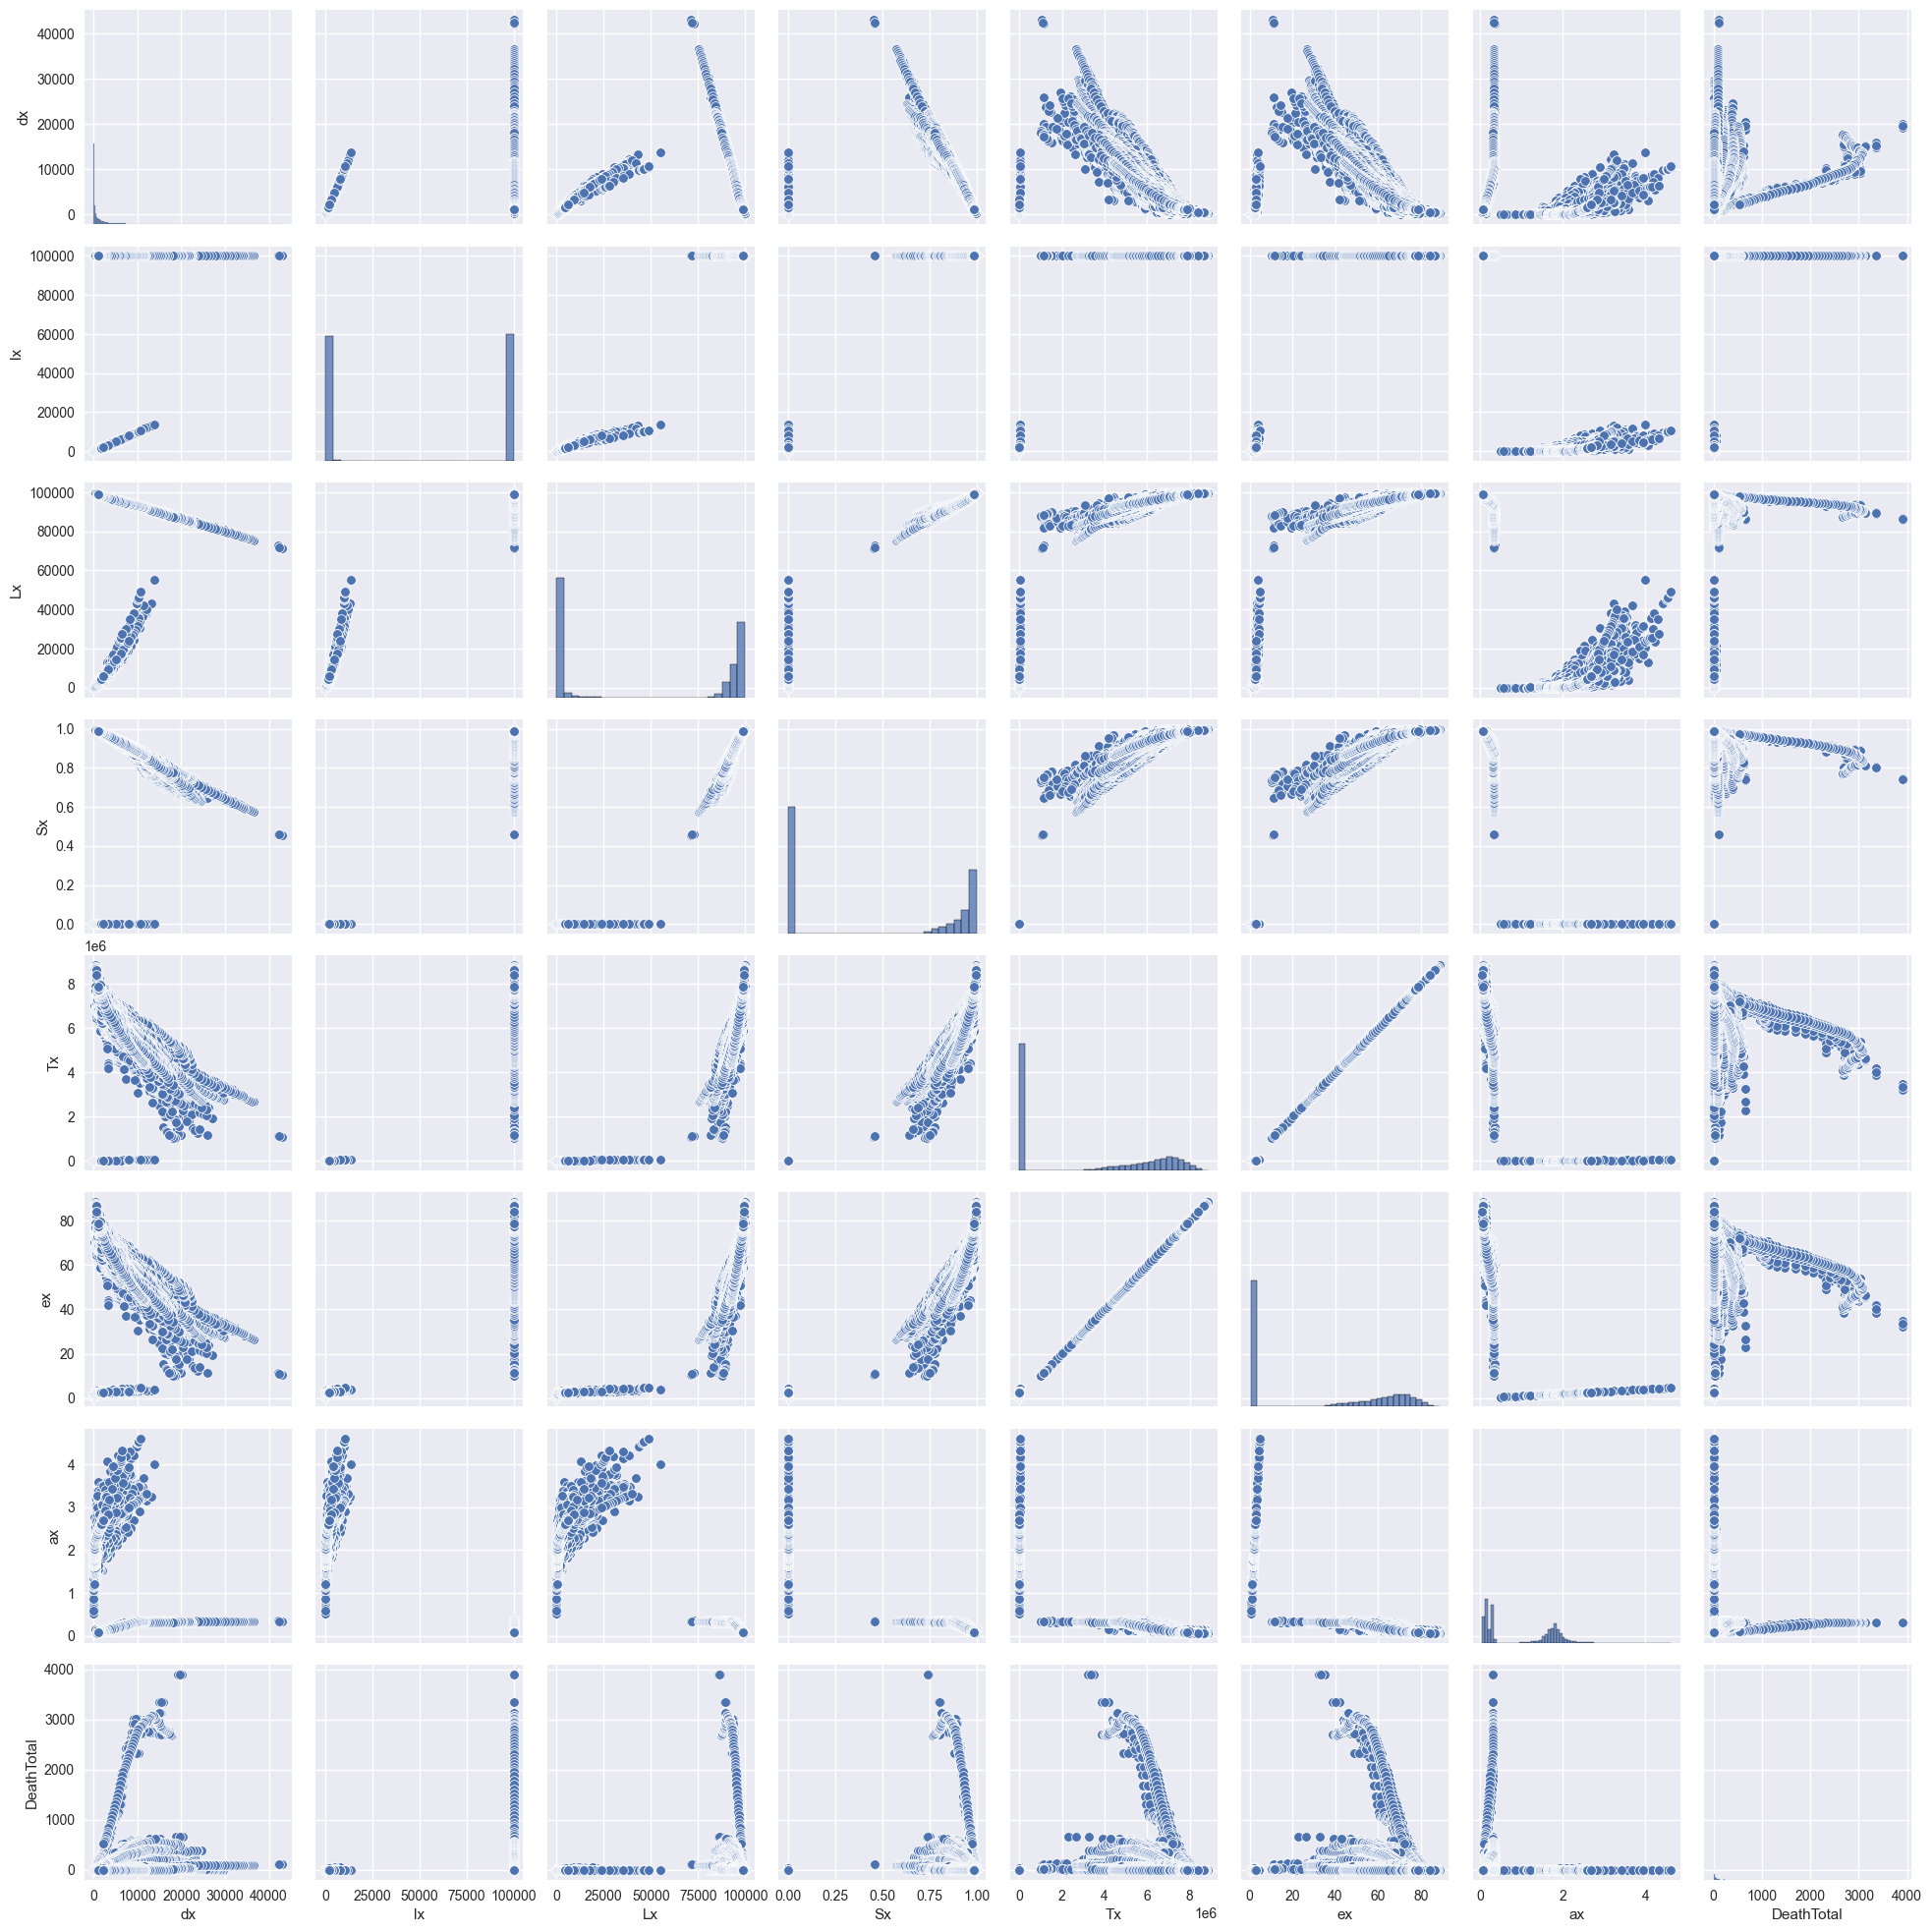

In [206]:
import seaborn as sns

sns.pairplot(df_lin_reg[["dx", "lx", "Lx", "Sx", "Tx", "ex", "ax", "DeathTotal"]])

### Feature Engineering

In [244]:
def generate_lag_features(df, features, time_col, group_col, lags):
    df = df.sort_values([group_col, time_col]).copy()
    cols = []
    for feature in features:
        for lag in lags:
            lagged_col_name = f'{feature}_lag_{lag}'
            df[lagged_col_name] = df.groupby(group_col)[feature].shift(lag)
            cols.append(lagged_col_name)
    return df, cols

# Использование:
lags = [5, 10, 15]
df_new, new_features = generate_lag_features(df_lin_reg, features, time_column, index_column, lags)
df_new = df_new.dropna(subset=new_features)

<Axes: >

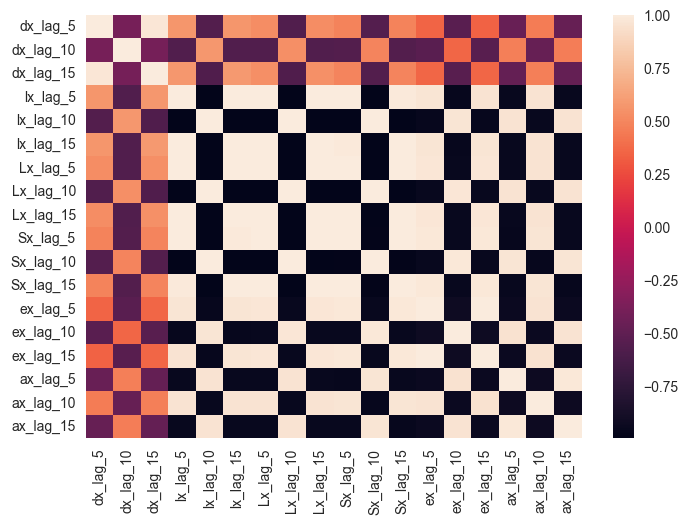

In [233]:
sns.heatmap(df_new[new_features].corr())

In [236]:
import numpy as np

def remove_correlated_features(df, features, corr_threshold=0.9):
    corr_matrix = df[features].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    return [f for f in features if f not in to_drop]

new_features_3 = remove_correlated_features(df_new, new_features, corr_threshold=0.75)


In [239]:
import statsmodels.api as sm

Y = df_new[target]
X = df_new[new_features_3]
# X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

In [240]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             DeathTotal   R-squared (uncentered):                   0.066
Model:                            OLS   Adj. R-squared (uncentered):              0.066
Method:                 Least Squares   F-statistic:                              2392.
Date:                Wed, 12 Nov 2025   Prob (F-statistic):                        0.00
Time:                        13:25:19   Log-Likelihood:                     -6.4402e+05
No. Observations:              101630   AIC:                                  1.288e+06
Df Residuals:                  101627   BIC:                                  1.288e+06
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dx_lag_5       0.0003      0.000      2.806      0.005    9.84e-05       0.001
dx_lag_10      0.0067   7.91e-05     84.703      0.000       0.007       0.007
lx_lag_5   -4.049e-05   8.81e-06     -4.598      0.000   -5.78e-05   -2.32e-05
==============================================================================
Omnibus:                   205884.156   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        482047584.370
Skew:                          17.142   Prob(JB):                         0.00
Kurtosis:                     338.649   Cond. No.                         19.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [243]:
df_new

SortOrder  LocID Notes ISO3_code ISO2_code  SDMX_code  \
Location    Time                                                          
Afghanistan 1952      143.0      4   NaN       AFG        AF        4.0   
            1952      143.0      4   NaN       AFG        AF        4.0   
            1952      143.0      4   NaN       AFG        AF        4.0   
            1953      143.0      4   NaN       AFG        AF        4.0   
            1953      143.0      4   NaN       AFG        AF        4.0   
...                     ...    ...   ...       ...       ...        ...   
Zimbabwe    2023       83.0    716   NaN       ZWE        ZW      716.0   
            2023       83.0    716   NaN       ZWE        ZW      716.0   
            2023       83.0    716   NaN       ZWE        ZW      716.0   
            2023       83.0    716   NaN       ZWE        ZW      716.0   
            2023       83.0    716   NaN       ZWE        ZW      716.0   

                  LocTypeID   LocTypeName  ParentID  VarID  ...  Lx_lag_15  \
Location    Time                                            ...              
Afghanistan 1952        4.0  Country/Area    5501.0      2  ...  80049.159   
            1952        4.0  Country/Area    5501.0      2  ...      0.539   
            1952        4.0  Country/Area    5501.0      2  ...  82687.232   
            1953        4.0  Country/Area    5501.0      2  ...      1.552   
            1953        4.0  Country/Area    5501.0      2  ...  81132.267   
...                     ...           ...       ...    ...  ...        ...   
Zimbabwe    2023        4.0  Country/Area     910.0      2  ...  96959.290   
            2023        4.0  Country/Area     910.0      2  ...    151.399   
            2023        4.0  Country/Area     910.0      2  ...  96764.452   
            2023        4.0  Country/Area     910.0      2  ...     31.201   
            2023        4.0  Country/Area     910.0      2  ...  97415.145   

                  Sx_lag_5  Sx_lag_10 Sx_lag_15 ex_lag_5  ex_lag_10  \
Location    Time                                                      
Afghanistan 1952  0.672881   0.000000  0.656015  28.5836     1.5435   
            1952  0.000000   0.661139  0.000000   1.5234    27.9711   
            1952  0.666248   0.000000  0.680493  28.3940     1.5064   
            1953  0.000000   0.685080  0.000000   1.5037    29.2748   
            1953  0.689601   0.000000  0.668104  29.7139     1.5889   
...                    ...        ...       ...      ...        ...   
Zimbabwe    2023  0.963597   0.000000  0.958266  64.5438     1.7192   
            2023  0.000000   0.959417  0.000000   2.1494    60.1347   
            2023  0.960228   0.000000  0.956222  62.3601     1.7069   
            2023  0.000000   0.957143  0.000000   2.1143    59.8805   
            2023  0.958509   0.000000  0.962904  60.2264     1.9739   

                  ex_lag_15  ax_lag_5  ax_lag_10  ax_lag_15  
Location    Time                                             
Afghanistan 1952    27.5467  0.330000   1.543500   0.330000  
            1952     1.5069  1.523400   0.330000   1.506900  
            1952    28.8345  0.330000   1.506400   0.350000  
            1953     1.5810  1.503700   0.350000   1.581000  
            1953    28.1563  0.350000   1.588900   0.330000  
...                     ...       ...        ...        ...  
Zimbabwe    2023    61.5300  0.168264   1.719200   0.148376  
            2023     1.8224  2.149400   0.145311   1.822400  
            2023    57.7174  0.142896   1.706900   0.157751  
            2023     1.6560  2.114300   0.155108   1.656000  
            2023    62.2889  0.151678   1.973900   0.170869  

[101630 rows x 48 columns]

In [245]:

from linearmodels.panel import PanelOLS

df_new_panel = df_new.set_index(['Location', 'Time'])

# Зависимая переменная
y = df_new_panel['DeathTotal']

# Независимые переменные
X = df_new_panel[new_features]

# Добавим константу для модели
import statsmodels.api as sm
X = sm.add_constant(X)

# Обучение fixed effect модели с фиксированными эффектами по Location (entity_effects=True)
model = PanelOLS(y, X, entity_effects=True)
results = model.fit()

print(results.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:             DeathTotal   R-squared:                        0.0655
Estimator:                   PanelOLS   R-squared (Between):              0.0276
No. Observations:              101630   R-squared (Within):               0.0655
Date:                Wed, Nov 12 2025   R-squared (Overall):              0.0508
Time:                        13:30:43   Log-likelihood                -6.183e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      394.56
Entities:                         237   P-value                           0.0000
Avg Obs:                       428.82   Distribution:               F(18,101375)
Min Obs:                       417.00                                           
Max Obs:                       429.00   F-statistic (robust):             394.56
                            